# В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru. 
Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

In [1]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
tqdm.pandas()
#%pylab inline
import re
from nltk.corpus import stopwords
import pymorphy3

In [3]:
responses = []
with bz2.BZ2File('d:\\ml\\nlp\\banki\\banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:10, 2847.09it/s]


In [4]:
responses[1]

{'city': 'г. Новосибирск',
 'rating_not_checked': False,
 'title': 'Не могу пользоваться услугой Сбербанк он-лайн',
 'num_comments': 0,
 'bank_license': 'лицензия № 1481',
 'author': 'Foryou',
 'bank_name': 'Сбербанк России',
 'datetime': '2015-06-08 11:09:57',
 'text': 'Доброго дня! Являюсь держателем зарплатной карты , выданной Сбербанком России. В 2008 году сменила фамилию, предоставила в банк \xa0документы (копию нового паспорта, свидетельства о браке), мне перевыпустили карту на фамилию мужа ТОКАРЕВА МАРИЯ АЛЕКСАНДРОВНА (девичья \xa0- СЕКЛЕТИНА). \xa0 Возникла необходимость подключить услугу Сбербанк онлайн, НЕ ПОЛУЧИЛОСЬ (на главной странице на отображались мои карты). Связалась с техническим специалистом отделения Сбербанка в котором обслуживалась. Он пояснил, что в базе банка, я все ещё под девичьей фамилией СЕКЛЕТИНА. Предложил выслать сканы необходимых документов. Выслала, оставив контакты, звонка так и не дождалась. Ч/з некоторое время звоню сама, объясняю ситуацию, меня про

# Часть 1. Анализ текстов
Посчитайте количество отзывов в разных городах и на разные банки.
Постройте гистограмы длин слов в символах и в словах.
Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

In [5]:
#грузим json в датафрейм
df = pd.json_normalize(responses)[['author', 'bank_name', 'city', 'datetime', 'rating_grade', 'text', 'title', 'bank_license', 'num_comments', 'rating_not_checked']]
df.head()

,author,bank_name,city,datetime,rating_grade,text,title,bank_license,num_comments,rating_not_checked
0,uhnov1,Бинбанк,г. Москва,2015-06-08 12:50:54,NaN,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,лицензия № 2562,0,False
1,Foryou,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,NaN,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,лицензия № 1481,0,False
2,Vladimir84,Бинбанк,г. Москва,2015-06-05 20:14:28,NaN,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,лицензия № 2562,1,False
3,643609,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,NaN,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...,лицензия № 1481,2,False
4,anfisa-2003,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,NaN,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку,лицензия № 2766,1,False


## EDA

In [6]:
# смотрим информацию по df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   author              153479 non-null  object 
 1   bank_name           153499 non-null  object 
 2   city                138325 non-null  object 
 3   datetime            153499 non-null  object 
 4   rating_grade        88658 non-null   float64
 5   text                153499 non-null  object 
 6   title               153499 non-null  object 
 7   bank_license        153498 non-null  object 
 8   num_comments        153499 non-null  int64  
 9   rating_not_checked  153499 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [7]:
len (df)

153499

In [8]:
# смотрим пропуски
df.isnull().sum()

author                   20
bank_name                 0
city                  15174
datetime                  0
rating_grade          64841
text                      0
title                     0
bank_license              1
num_comments              0
rating_not_checked        0
dtype: int64

## Посчитайте количество отзывов в разных городах и на разные банки

In [9]:
n_reply = df.groupby(['city', 'bank_name'])['rating_not_checked'].count().reset_index()
n_reply.columns = ['Город temp', 'Банк', 'Количество отзывов']
n_reply.sort_values(by=['Количество отзывов'], ascending=False, inplace= True)
n_reply

,Город temp,Банк,Количество отзывов
7453,г. Москва,Сбербанк России,8146
7160,г. Москва,Альфа-Банк,3871
7437,г. Москва,Русский Стандарт,2801
7206,г. Москва,ВТБ 24,2714
12394,г. Санкт-Петербург,Сбербанк России,2434
...,...,...,...
7733,"г. Москва, Отделение ""Жулебинское""",Московский Кредитный Банк,1
7734,"г. Москва, ""Китай-город""",Фора-Банк,1
7735,"г. Москва, Ветошный пер",Восточный Экспресс Банк,1
7736,"г. Москва, Видное",Сбербанк России,1


In [10]:
from nltk.tokenize import word_tokenize

In [11]:
# уберем мусор в городе , оставим только город
def apwords(w):
    tokens = word_tokenize(w)
    return tokens[1]

n_reply['Город'] = n_reply['Город temp'].apply(apwords)

In [12]:
n_reply.drop('Город temp', axis= 1 , inplace= True )
n_reply[['Город', 'Банк', 'Количество отзывов']]


,Город,Банк,Количество отзывов
7453,Москва,Сбербанк России,8146
7160,Москва,Альфа-Банк,3871
7437,Москва,Русский Стандарт,2801
7206,Москва,ВТБ 24,2714
12394,Санкт-Петербург,Сбербанк России,2434
...,...,...,...
7733,Москва,Московский Кредитный Банк,1
7734,Москва,Фора-Банк,1
7735,Москва,Восточный Экспресс Банк,1
7736,Москва,Сбербанк России,1


## Постройте гистограмы длин слов в символах и в словах

In [13]:
# считаем длину отзывов в символах
sym_length = df['text'].apply(len)
sym_length

0         1523
1         1026
2          588
3          740
4         1896
          ... 
153494     353
153495     727
153496    5388
153497     692
153498     489
Name: text, Length: 153499, dtype: int64

<Axes: ylabel='Frequency'>

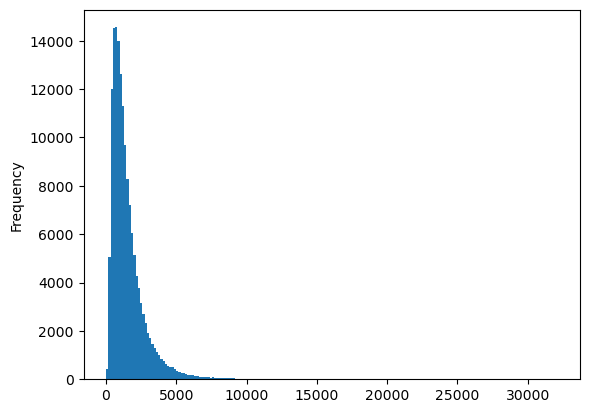

In [14]:
# гистограмма длин отзывов в символах
sym_length.plot(kind = 'hist', bins = 200)

In [15]:
tqdm.pandas()

In [16]:
# Посчитаем длину каждого отзыва в словах
def reply_len(w):
    tokens = word_tokenize(w)
    return len(tokens)
df['Len Reply'] = df['text'].progress_map(reply_len)
df

100%|█████████████████████████████████████████████████████████████████████████| 153499/153499 [05:08<00:00, 497.07it/s]


,author,bank_name,city,datetime,rating_grade,text,title,bank_license,num_comments,rating_not_checked,Len Reply
0,uhnov1,Бинбанк,г. Москва,2015-06-08 12:50:54,NaN,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,лицензия № 2562,0,False,252
1,Foryou,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,NaN,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,лицензия № 1481,0,False,174
2,Vladimir84,Бинбанк,г. Москва,2015-06-05 20:14:28,NaN,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,лицензия № 2562,1,False,111
3,643609,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,NaN,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...,лицензия № 1481,2,False,149
4,anfisa-2003,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,NaN,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку,лицензия № 2766,1,False,351
...,...,...,...,...,...,...,...,...,...,...,...
153494,Вера,Ситибанк,None,2005-05-18 14:38:00,5.0,"Слишком большой банк, не всегда учитывает нашу...",Не все так страшно,лицензия № 2557,0,False,68
153495,Kirill,Ситибанк,None,2005-04-14 15:25:00,3.0,"Вы сами виноваты в своих проблемах, кроме пред...",А вы договор читали?,лицензия № 2557,0,False,142
153496,AlexU-post,Росбанк,None,2005-04-08 14:07:00,1.0,Уважаемое руководство банка «ОВК»! Я проживаю ...,"Филиал банка ""ОВК"" в г. Иваново",лицензия № 2272,1,False,911
153497,Ирина,Альфа-Банк,None,2005-04-14 15:16:00,1.0,Пробовала 10.04.05 оформить товар в кредит в А...,В Альфа-Банк больше обращаться не буду.,лицензия № 1326,0,False,137


In [17]:
df.head(1)

,author,bank_name,city,datetime,rating_grade,text,title,bank_license,num_comments,rating_not_checked,Len Reply
0,uhnov1,Бинбанк,г. Москва,2015-06-08 12:50:54,NaN,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,лицензия № 2562,0,False,252


<Axes: ylabel='Frequency'>

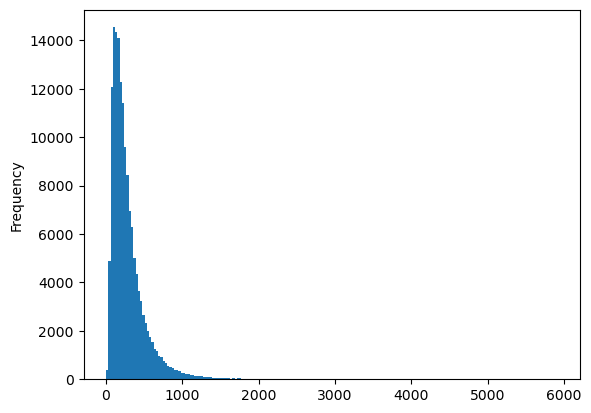

In [18]:
df['Len Reply'].plot(kind = 'hist', bins = 200)

## Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

In [19]:
nltk.download('punkt')
# загрузим знаки пунктуации
from string import punctuation
punctuation

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yuril\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
# загрузим счетчик
from collections import Counter

In [21]:
%%time
# убираем знаки препинания
corpus = [token for response in df.text for token in word_tokenize(response) if token not in punctuation]
print(len(corpus))
corpus[5]

36766261
CPU times: total: 4min 46s
Wall time: 5min 4s


'клиентом'

In [22]:
corpus

['Добрый',
 'день',
 'Я',
 'не',
 'являюсь',
 'клиентом',
 'банка',
 'и',
 'поручителем',
 'по',
 'кредитному',
 'договору',
 'а',
 'также',
 'не',
 'являюсь',
 'каким-либо',
 'другим',
 'лицом',
 'письменно',
 'оформившим',
 'отношения',
 'с',
 'банком',
 'по',
 'поводу',
 'урегулирования',
 'чьей-либо',
 'задолженности',
 'Начиная',
 'с',
 'марта',
 '2015',
 'года',
 'начали',
 'приходить',
 'бесконечные',
 'письма',
 'из',
 'ООО',
 '``',
 'Примо',
 'коллект',
 "''",
 'на',
 'мой',
 'адрес',
 'город',
 'Москва',
 'Уваровский',
 'переулок',
 'дом',
 '10',
 'квартира',
 '111',
 'с',
 'угрозами',
 'о',
 'возбуждении',
 'уголовного',
 'дела',
 'в',
 'отношении',
 'гражданина',
 'Филиппова',
 'Эдуарда',
 'Владимировича',
 'который',
 'уклоняется',
 'от',
 'уплаты',
 'взятых',
 'им',
 'кредитов',
 'договор',
 '№',
 '81014',
 'от',
 '20.10.2013',
 'года',
 'и',
 'договор',
 '№',
 '2464946',
 'от',
 '09.10.2014',
 'года',
 'Со',
 'всей',
 'ответственностью',
 'хочу',
 'Вас',
 'заверить',
 'ч

## Найдите 10 самых частых слов

In [23]:
# прогоним корпус через счетчик
freq_dict = Counter(corpus)

# получим список 10 самых частых слов в корпусе 
freq_dict.most_common(10)

[('в', 1169557),
 ('и', 980761),
 ('не', 816419),
 ('на', 638715),
 ('что', 603171),
 ('я', 443478),
 ('с', 428021),
 ('по', 338743),
 ('мне', 293980),
 ('банка', 235175)]

## Найдите 10 самых частыx слов без стоп слов

In [24]:
m = pymorphy3.MorphAnalyzer()

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yuril\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
len (corpus)


36766261

In [27]:
list (punctuation)

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~']

In [28]:
%%time
# очень долго все считает на полом объеме. Ограничу объем первыми 20000 записей
mystopwords = stopwords.words('russian') + list (punctuation) +['тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой', '№', ',','``', '...', "''"]
words_without_stop = [token for response in df.text[:20000] for token in word_tokenize(response) if token not in mystopwords]
print(len(words_without_stop))
words_without_stop[:10]

2892133
CPU times: total: 40 s
Wall time: 43 s


['Добрый',
 'день',
 'Я',
 'являюсь',
 'клиентом',
 'банка',
 'поручителем',
 'кредитному',
 'договору',
 'являюсь']

In [29]:
freq_dict = Counter(words_without_stop)

# получим список 10 самых частых слов в корпусе 
freq_dict.most_common(10)

[('банка', 29776),
 ('банк', 20245),
 ('это', 17673),
 ('В', 17608),
 ('Я', 15522),
 ('деньги', 13708),
 ('карты', 11008),
 ('карту', 10271),
 ('день', 9423),
 ('И', 7892)]

In [30]:
# нужно переводить все в нижний регистр, считать заново
words_without_stop = [s.lower() for s in words_without_stop]

In [31]:
words_without_stop2 = [token for response in words_without_stop for token in word_tokenize(response) if token not in mystopwords]

In [32]:
freq_dict = Counter(words_without_stop2)

# получим список 10 самых частых слов в корпусе 
freq_dict.most_common(10)

[('банка', 33803),
 ('банк', 25836),
 ('это', 20424),
 ('деньги', 14636),
 ('карты', 11185),
 ('карту', 10603),
 ('день', 9587),
 ('кредит', 8597),
 ('заявление', 7855),
 ('банке', 7842)]

## Найдите 10 самых частых лемм

## Препроцессинг

In [33]:
ru_words = re.compile("[А-Яа-я]+")
def words_only(text):
    return " ".join(ru_words.findall(text))

def lemmatize(text, mystem=m):
    try:
        return " ".join([m.parse(w)[0].normal_form for w in text.split(' ')]).strip()  
    except:
        return " "

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))

In [34]:
# Лемматизацию делаем на 20000 позиций 
response_lemmas = df.text.astype('str')[:20000].progress_apply(preprocess)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [12:51<00:00, 25.91it/s]


In [35]:
token_lemmas = [token for response in response_lemmas for token in word_tokenize(response) if token not in mystopwords]
token_lemmas[10:]

['лицо',
 'письменно',
 'оформить',
 'отношение',
 'банк',
 'повод',
 'урегулирование',
 'чей',
 'либо',
 'задолженность',
 'начинать',
 'март',
 'год',
 'начать',
 'приходить',
 'бесконечный',
 'письмо',
 'ооо',
 'прить',
 'коллект',
 'адрес',
 'город',
 'москва',
 'уваровский',
 'переулок',
 'дом',
 'квартира',
 'угроза',
 'возбуждение',
 'уголовный',
 'дело',
 'отношение',
 'гражданин',
 'филиппов',
 'эдуард',
 'владимирович',
 'уклоняться',
 'уплата',
 'взять',
 'кредит',
 'договор',
 'год',
 'договор',
 'год',
 'весь',
 'ответственность',
 'хотеть',
 'заверить',
 'вышеуказанный',
 'гражданин',
 'разыскивать',
 'знак',
 'адрес',
 'зарегистрировать',
 'образ',
 'удостовериться',
 'подлинность',
 'документ',
 'оформить',
 'имя',
 'кредитный',
 'договор',
 'малый',
 'мера',
 'понятно',
 'почему',
 'ваш',
 'милость',
 'должный',
 'переживать',
 'бояться',
 'имущество',
 'письмо',
 'доставлять',
 'серьёзный',
 'неудобство',
 'нарушать',
 'гражданский',
 'право',
 'нарушать',
 'закон',
 

In [36]:
freq_dict = Counter(token_lemmas)
# получим список 10 самых частых лемм 
freq_dict.most_common(10)

[('банк', 84772),
 ('карта', 35728),
 ('это', 34622),
 ('день', 20382),
 ('деньга', 19987),
 ('сотрудник', 18439),
 ('кредит', 18057),
 ('всё', 17882),
 ('клиент', 16526),
 ('отделение', 14685)]

## Найдите 10 самых частых существительных

In [37]:
m.parse(response_lemmas[100])

[Parse(word='здравствуйте уважаемый сотрудник банк декабрь год взять потребительский кредит год досрочно погасить данный момент пытаться оформить ипотека друг банк дать погашение кредит дойти бки справка закрытие кредит помочь банк сказать ждать обновление кредитный история подача заявка связь это хотеться узнать часто дать ваш банк передаваться бки местный отделение банк телефон горячий линия смочь дать однозначный ответ говорить неделя третий месяц результат это возникнуть вопрос квартира хотеть приобрести оформить бронь неделя закончиться случай окончание квартира продать покупатель очень хотеться опоздать процесс обновление данные проконтролировать случиться непредвиденный ситуация результат заставить долго ждать', tag=OpencorporaTag('INFN,impf,tran'), normal_form='здравствуйте уважаемый сотрудник банк декабрь год взять потребительский кредит год досрочно погасить данный момент пытаться оформить ипотека друг банк дать погашение кредит дойти бки справка закрытие кредит помочь банк с

In [38]:
# выделение существительных из текста
def parsing_nouns(txt):
    try:
        return  " ".join([m.parse(w)[0].word for w in txt.split() if 'NOUN' in m.parse(w)[0].tag])
    except:
        return " "
     

In [39]:
response_nouns = response_lemmas.progress_apply(parsing_nouns)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:49<00:00, 42.59it/s]


In [40]:
response_nouns[:10]

0    день клиент банк поручитель договор лицо отнош...
1    день держатель карта сбербанк россия год фамил...
2    заявление карта покупка интернет магазин сумма...
3    день счёт сбербанк юр лицо договор комиссия пе...
4    г кредит банк сумма рубль год менеджер срок кр...
5    вкладчик руб мысль последствие внесение наруше...
6    заявление получение отделение сбербанк переоди...
7    н новость май унификация н эмоция удруч н униф...
8    сотрудник банк телефон форма информация наруше...
9    день заёмщик банк втб год кредит руб май месяц...
Name: text, dtype: object

In [41]:
nouns_tokenized = [token for response in response_nouns for token in word_tokenize(response) if token not in mystopwords]
nouns_tokenized[:10]

['день',
 'клиент',
 'банк',
 'поручитель',
 'договор',
 'лицо',
 'отношение',
 'банк',
 'повод',
 'урегулирование']

In [42]:
freq_dict = Counter(nouns_tokenized)
freq_dict.most_common(10)

[('банк', 84772),
 ('карта', 35728),
 ('день', 20382),
 ('деньга', 19987),
 ('сотрудник', 18439),
 ('кредит', 18057),
 ('клиент', 16526),
 ('отделение', 14685),
 ('счёт', 14345),
 ('сумма', 13973)]

## Постройте кривые Ципфа и Хипса

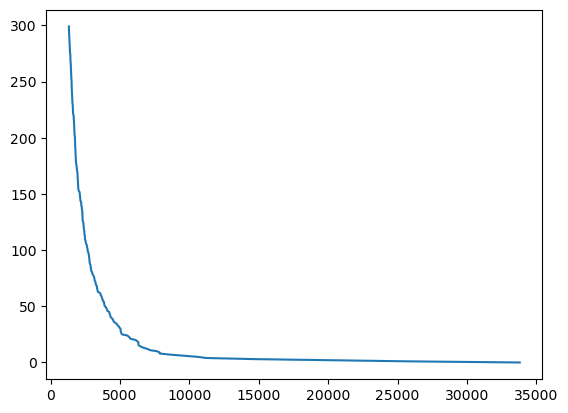

In [43]:
# Берем базу на 20000 без стоп-слов .
# частотность слов убывает очень быстро
freq_dict = Counter(words_without_stop2)

# кривая Ципфа
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [44]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []

for index, row in tqdm(df[:20000].iterrows(), total = len(df[:20000])):
  tokens = word_tokenize(row['text'])
  cnt.update([token for token in tokens if token not in punctuation])
  n_words.append(len(cnt))
  n_tokens.append(sum(cnt.values()))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:51<00:00, 389.45it/s]


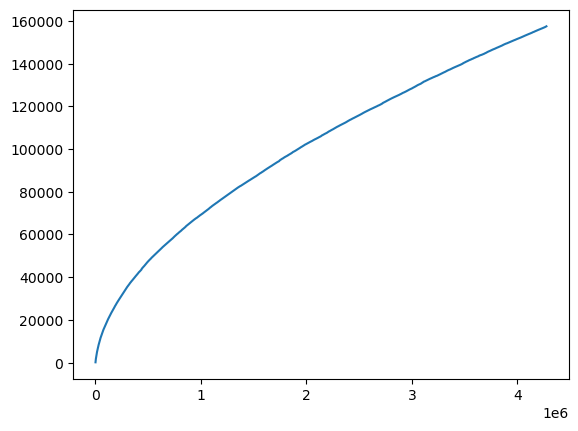

In [45]:
fig, ax = plt.subplots()
ax.plot(n_tokens, n_words)
plt.show()

## Какое слово встречается чаще, "сотрудник" или "клиент"?

In [46]:
freq_dict = Counter(token_lemmas)

# - какое слово встречается чаще, "сотрудник" или "клиент"? Ответ: слово "сотрудник" встречается чаще, чем слово "клиент"
print("сотрудник:", freq_dict["сотрудник"])
print("клиент:", freq_dict["клиент"])

сотрудник: 18439
клиент: 16526


## сколько раз встречается слова "мошенничество" и "доверие"?

In [47]:
print("мошенничество:", freq_dict["мошенничество"])
print("доверие:", freq_dict["доверие"])

мошенничество: 418
доверие: 289


## В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5.  Используйте меру tf-idf, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [48]:
df['rating_grade'].value_counts()

rating_grade
1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: count, dtype: int64

In [49]:
# положительные отзывовы
df_positive = df[['text', 'rating_grade']].loc[df['rating_grade'] == 5]
df_positive.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14713 entries, 98 to 153498
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          14713 non-null  object 
 1   rating_grade  14713 non-null  float64
dtypes: float64(1), object(1)
memory usage: 344.8+ KB


In [51]:
# препроцессинг отзывов с положительной оценкой
df_positive.text = df_positive.text.astype('str').progress_apply(preprocess)

100%|████████████████████████████████████████████████████████████████████████████| 14713/14713 [09:50<00:00, 24.93it/s]


In [52]:
df_positive.head(2)

,text,rating_grade
98,досрочно закрывать вклад отпуск жена заказыват...,5.0
122,хотеть открыть вклад доходный год процент начи...,5.0


In [53]:
# загружаем библиотеки
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
# создадим векторизатор для разбивки на униграммы
positive_response_unigrams = TfidfVectorizer()
# сформируем "мешок слов" с униграммами для полож.отзывов
bow_positive_unigrams = positive_response_unigrams.fit_transform(df_positive.text)

In [55]:
feature_names = positive_response_unigrams.get_feature_names_out()
tfidf_scores = bow_positive_unigrams.toarray()[0]

# Сортировка слов по значениям TF-IDF
sorted_keywords = [word for _, word in sorted(zip(tfidf_scores, feature_names), reverse=True)]

print("Ключевые слова:", sorted_keywords)

Ключевые слова: ['ленсовет', 'озерко', 'прикрыть', 'вклад', 'доступность', 'нести', 'значительный', 'спб', 'приём', 'заказывать', 'отпуск', 'наталья', 'закрывать', 'жаль', 'профессионально', 'жена', 'отказать', 'досрочно', 'успех', 'заказать', 'заметить', 'офис', 'заранее', 'забыть', 'лишний', 'желать', 'брать', 'хотя', 'сумма', 'быстро', 'банк', 'работать', 'кредит', 'деньга', 'сотрудник', 'ёрзать', 'ёрзание', 'ёмкость', 'ёмко', 'ёмкий', 'ёлочный', 'ёлочка', 'ёлкин', 'ёлка', 'ёжик', 'ёж', 'ёвр', 'яя', 'ящичек', 'ящик', 'яшкова', 'яшин', 'ячейка', 'ячеечный', 'яценко', 'яхтенный', 'яхта', 'яузкий', 'ястребова', 'ясный', 'ясность', 'ясновидящий', 'ясно', 'ясеневый', 'ясеневский', 'ясельный', 'яс', 'ярый', 'ярцевский', 'ярцев', 'ярсоцбанк', 'ярпортал', 'ярость', 'яростный', 'яростно', 'ярославский', 'ярославович', 'ярославль', 'ярославкий', 'ярославка', 'ярослав', 'яров', 'яро', 'ярмулковский', 'ярмолюк', 'ярмо', 'ярмарка', 'ярлыковый', 'яркость', 'ярко', 'яркий', 'ярина', 'японский', 'я

In [56]:
sums = bow_positive_unigrams.sum(axis=0)

# объединяем каждое слово и его tf-idf, сортируем по убыванию
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['униграмма','Ранг по tf-idf'])
ranking = ranking.sort_values('Ранг по tf-idf', ascending=False)
ranking[:20]

,униграмма,Ранг по tf-idf
1370,банк,1210.746919
10663,карта,719.513623
35388,это,574.749279
4287,всё,559.532985
3473,вклад,514.537458
12101,кредит,491.700942
19920,очень,465.217049
19309,отделение,448.305722
6247,день,400.983047
11049,клиент,397.011806


In [57]:
# биграммы
# Создадим векторизатор для разбивки на биграммы
positive_response_bigrams = TfidfVectorizer(ngram_range=(2, 2))
# сформируем "мешок слов" с биграммами для полож.отзывов
bow_positive_bigrams = positive_response_bigrams.fit_transform(df_positive.text)


In [58]:
feature_names = positive_response_bigrams.get_feature_names_out()
sums = bow_positive_bigrams.sum(axis=0)

# объединяем каждое слово и его tf-idf, сортируем по убыванию
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['Биграмма','Ранг по tf-idf'])
ranking = ranking.sort_values('Ранг по tf-idf', ascending=False)
ranking[:20]

,Биграмма,Ранг по tf-idf
814581,это банк,88.798507
229842,интернет банк,87.505267
278779,кредитный карта,83.318274
691223,сотрудник банк,79.272568
255703,клиент банк,64.054569
821064,являться клиент,52.946583
426855,отделение банк,52.352158
669262,следующий день,51.514138
93793,всё вопрос,48.429130
11134,альфа банк,46.478217


In [114]:
# отрицательные отзывы - сократил до 10000 - из-за ошибок по памяти
df_negative = df[['text', 'rating_grade']].loc[df['rating_grade'] == 1][:10000]
df_negative.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 19 to 36855
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          10000 non-null  object 
 1   rating_grade  10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 234.4+ KB


In [115]:
# препроцессинг
df_negative.text = df_negative.text.astype('str').progress_apply(preprocess)


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:46<00:00, 21.42it/s]


In [116]:
# создадим векторизатор для разбивки на униграммы
negative_response_unigrams = TfidfVectorizer()
# сформируем "мешок слов" с униграммами для негативных отзывов
bow_negative_unigrams = negative_response_unigrams.fit_transform(df_negative.text)

In [117]:
df_negative.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 19 to 36855
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          10000 non-null  object 
 1   rating_grade  10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 234.4+ KB


In [118]:
feature_names = negative_response_unigrams.get_feature_names_out()

In [119]:

sums = bow_negative_unigrams.sum(axis=0)

# объединяем каждое слово и его tf-idf, сортируем по убыванию
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['униграмма','Ранг по tf-idf'])
ranking = ranking.sort_values('Ранг по tf-idf', ascending=False)
ranking[:20]

,униграмма,Ранг по tf-idf
893,банк,801.349566
7808,карта,603.124446
26287,это,410.014129
4517,деньга,389.384497
8822,кредит,335.313428
4516,день,324.206324
14233,отделение,321.410171
22017,сотрудник,312.201217
22829,счёт,288.191677
2346,вклад,285.165630


In [120]:
# биграммы
# Создадим векторизатор для разбивки на биграммы
negative_response_bigrams = TfidfVectorizer(ngram_range=(2, 2))
# сформируем "мешок слов" с биграммами для полож.отзывов
bow_negative_bigrams = negative_response_bigrams.fit_transform(df_negative.text)

In [121]:
feature_names = negative_response_bigrams.get_feature_names_out()
sums = bow_negative_bigrams.sum(axis=0)

# объединяем каждое слово и его tf-idf, сортируем по убыванию
data = []
for col, term in enumerate(feature_names):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['Биграмма','Ранг по tf-idf'])
ranking = ranking.sort_values('Ранг по tf-idf', ascending=False)
ranking[:20]

,Биграмма,Ранг по tf-idf
518153,сотрудник банк,77.345963
100673,денежный средство,72.228344
85517,горячий линия,63.876151
317293,отделение банк,61.282625
207439,кредитный карта,60.013202
610834,это банк,52.887722
246292,написать заявление,52.501631
31159,ваш банк,48.180932
172736,интернет банк,45.635487
108889,добрый день,42.786079


## Часть 2. Тематическое моделирование

Постройте несколько тематических моделей коллекции документов с разным числом тем. 
Приведите примеры понятных (интерпретируемых) тем.
Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

In [66]:
# грузим библиотеки
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [67]:
#берем леммы уже готовые
texts = [text.split() for text in response_lemmas]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [68]:
# создадим модель tf-idf на основании корпуса
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [69]:
# рассчитаем косинусную близость между векторами tf-idf
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [70]:
# содержательный анализ тем проведем с использованием модели LSI (латентно-семантического анализа) из библиотеки Gensim
from gensim.models import lsimodel

In [71]:
%%time
# после эксперементов остановился на 60 темах
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=20)

CPU times: total: 5.66 s
Wall time: 5.6 s


In [72]:
lsi.show_topics()

[(0,
  '0.191*"карта" + 0.133*"кредит" + 0.122*"вклад" + 0.117*"деньга" + 0.108*"счёт" + 0.107*"заявление" + 0.101*"сумма" + 0.099*"отделение" + 0.097*"сотрудник" + 0.097*"платёж"'),
 (1,
  '0.265*"вклад" + -0.246*"звонок" + -0.236*"номер" + -0.204*"кредит" + 0.192*"карта" + -0.162*"ваш" + -0.142*"поступать" + -0.141*"телефон" + -0.137*"данные" + -0.137*"персональный"'),
 (2,
  '0.614*"вклад" + -0.221*"карта" + 0.168*"очередь" + -0.162*"сбербанк" + -0.133*"банкомат" + 0.129*"открыть" + 0.115*"ставка" + -0.108*"платёж" + 0.107*"процент" + -0.106*"руб"'),
 (3,
  '0.328*"кредит" + 0.299*"страховка" + 0.212*"страхование" + -0.209*"номер" + 0.176*"договор" + -0.169*"карта" + 0.158*"погашение" + 0.146*"платёж" + 0.139*"сумма" + 0.134*"досрочный"'),
 (4,
  '-0.259*"вклад" + -0.199*"средство" + -0.190*"договор" + -0.176*"денежный" + -0.131*"комиссия" + 0.130*"заявка" + -0.129*"счёт" + 0.127*"очередь" + -0.122*"г" + -0.121*"руб"'),
 (5,
  '-0.296*"страховка" + -0.258*"страхование" + 0.249*"плат

In [73]:
# скорей всего надо делить выборки на разные банки, потому что услуги в банках разные и какие то темы могут принадлежать конкретным банкам

## Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). 
Можете ли вы их прокомментировать / объяснить? Эта часть задания может быть сделана с использованием gensim.

 (19,
  '0.237*"заявление" + -0.227*"заявка" + 0.176*"ваш" + 0.162*"страховка" + -0.153*"счёт" + -0.150*"договор" + -0.141*"альфа" + -0.138*"смс" + 0.135*"комиссия" + 0.132*"обращение"') - оформление страховки в альфе
(18,
  '-0.295*"комиссия" + 0.207*"карта" + 0.198*"кредит" + -0.184*"руб" + 0.172*"средство" + 0.164*"счёт" + -0.155*"сбербанк" + 0.153*"кредитный" + 0.151*"денежный" + 0.144*"погашение"') - погашение кредита в сбербанке
(16,
  '0.304*"руб" + 0.300*"комиссия" + 0.246*"заявка" + 0.238*"сбербанк" + -0.214*"альфа" + -0.182*"услуга" + -0.145*"счёт" + -0.142*"платёж" + -0.141*"деньга" + 0.134*"г"') - нет вариантов
(14,
  '-0.267*"заявка" + -0.212*"услуга" + 0.189*"кошелёк" + -0.187*"платёж" + 0.183*"карта" + -0.179*"смс" + 0.177*"заявление" + 0.151*"заблокировать" + 0.128*"киви" + 0.113*"курс"') - проблемы с платежами в сторону киви
(12,
  '-0.374*"курс" + 0.284*"сбербанк" + -0.268*"заявка" + -0.196*"валюта" + -0.183*"доллар" + -0.171*"евро" + 0.170*"терминал" + 0.141*"кошелёк" + 0.129*"платёж" + -0.112*"конвертация"') операции с валютой в сбербанке
(11,
  '0.373*"сбербанк" + -0.302*"банкомат" + -0.191*"кредитный" + 0.191*"страховка" + 0.181*"курс" + 0.179*"перевод" + 0.152*"номер" + -0.145*"карта" + -0.127*"лимит" + 0.124*"счёт"') - переводы а карту в сбербанке
(9,
  '-0.202*"кошелёк" + -0.184*"вклад" + -0.176*"карта" + -0.166*"заявка" + -0.143*"киви" + 0.129*"сбербанк" + 0.129*"денежный" + 0.123*"курс" + -0.118*"адресовать" + 0.114*"средство"') - нет вариантов

 (8,
  '-0.289*"кошелёк" + 0.279*"сбербанк" + -0.245*"страховка" + 0.233*"карта" + -0.217*"комиссия" + -0.205*"киви" + 0.181*"заявление" + -0.156*"перевод" + -0.148*"страхование" + -0.133*"курс" переводы на карту сбербанк
(6,
  '-0.406*"карта" + 0.218*"кошелёк" + -0.209*"комиссия" + 0.170*"терминал" + 0.165*"киви" + -0.158*"лимит" + -0.152*"кредитный" + 0.151*"деньга" + 0.127*"банкомат" + -0.125*"услуга"') - проблемы с кошельком в киви
(5,
  '0.295*"страховка" + 0.259*"страхование" + -0.250*"платёж" + 0.236*"сбербанк" + -0.162*"задолженность" + 0.149*"заявление" + 0.149*"заявка" + -0.147*"просрочка" + 0.144*"страховой" + 0.121*"документ"') - страхование услуг в сбере
(2,
  '-0.614*"вклад" + 0.221*"карта" + -0.168*"очередь" + 0.162*"сбербанк" + 0.133*"банкомат" + -0.129*"открыть" + -0.115*"ставка" + 0.109*"платёж" + -0.107*"процент" + 0.105*"руб"') - работа с банкоматами в сбере

Как я уже написал - разное кол-во услуг, разные услуги, разное кол-во офисов , нужна деталлизация выборок в разрезе банков,,,'),,,,,,,],,,,,,,,,,,,,] 

## Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

In [74]:
# у нас сильно разные выборки о кол-ву (положительных в 3 раза меньше ) . приведем объем выборок к одному знаменателю
len(df[df['rating_grade'] == 5]), len(df[df['rating_grade'] == 1])


(14713, 47387)

In [75]:
negative_sample = df[df['rating_grade'] == 1][['text', 'rating_grade']].sample(14713)

In [76]:
negative_sample

,text,rating_grade
3180,Выбрал МКБ в том числе из-за наличия онлайн си...,1.0
42659,Здравствуйте! Мне пришло предложение о взятии ...,1.0
78320,Я 07.06.2013 закрыл все карты и счета в банке ...,1.0
124276,В России начинают работать новые иностранные б...,1.0
41046,Подал кредитную заявку в банк через интернет. ...,1.0
...,...,...
26697,Добрый день! Взяла кредит в филиале СБЕРБАНКА ...,1.0
30403,Я уже писал об этом. Служба взыскания задолжен...,1.0
21312,Сегодня пришла в офис Коньково для получения в...,1.0
84435,"Ведь знали-же, что бесплатный сыр бывает тольк...",1.0


In [77]:
positive_sample = df[df['rating_grade'] == 5][['text', 'rating_grade']]

In [78]:
positive_sample

,text,rating_grade
98,Досрочно закрывали вклады перед отпуском. Жена...,5.0
122,"Хотел открыть вклад ""Доходный+"" под 19% год , ...",5.0
157,"Вчера, 3 июня, просидев в очереди более 3-х ча...",5.0
259,Сегодня открывал вклад в этом банке. Очередь б...,5.0
266,Моя история получения кредита в Ренессанс Кред...,5.0
...,...,...
153488,Пользуюсь банком 3 месяца - специально открыл ...,5.0
153489,А что писать? Ставки по вкладам высокие (до 13...,5.0
153491,А я с мужем обставила техникой совершенно нову...,5.0
153494,"Слишком большой банк, не всегда учитывает нашу...",5.0


In [79]:
itog = pd.concat([negative_sample, positive_sample])
itog.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29426 entries, 3180 to 153498
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          29426 non-null  object 
 1   rating_grade  29426 non-null  float64
dtypes: float64(1), object(1)
memory usage: 689.7+ KB


In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [81]:
# входящие признаки 
x = itog['text']

In [82]:
# создадим и обучим векторизатор tf-idf на отдельных словах - униграммах (с параметрами "по умолчанию")
tfidf = TfidfVectorizer()
x_vectorized = tfidf.fit_transform(x)
print("x_vectorized.shape: ", x_vectorized.shape)

x_vectorized.shape:  (29426, 155317)


In [83]:
# целевая переменная (не требует векторизации)
y = itog['rating_grade']

In [84]:
# Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
X_train, x_test, Y_train, y_test = train_test_split(x_vectorized, y, test_size=0.3, random_state=42)

## Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных -грам.

In [85]:
# загрузим необходимые библиотеки
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [86]:
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
# Trained the model
svm.fit(X_train, Y_train)


SVC(gamma=0.5)

In [87]:
# Сделаем прогноз на тестовой выборке
svm_test = svm.predict(x_test)
print(classification_report(svm_test, y_test))

              precision    recall  f1-score   support

         1.0       0.97      0.94      0.95      4579
         5.0       0.93      0.97      0.95      4249

    accuracy                           0.95      8828
   macro avg       0.95      0.95      0.95      8828
weighted avg       0.95      0.95      0.95      8828



In [88]:
# очень хорошие результаты. построим модель для биграмм
tfidf_bigrams = TfidfVectorizer(ngram_range = (2, 2))
x_vectorized_bigrams = tfidf_bigrams.fit_transform(x)
print("x_vectorized_bigrams.shape: ", x_vectorized_bigrams.shape)

x_vectorized_bigrams.shape:  (29426, 2363617)


In [89]:
# Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
X_train, x_test, Y_train, y_test = train_test_split(x_vectorized_bigrams, y, test_size=0.3, random_state=42)

In [90]:
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
# Trained the model
svm.fit(X_train, Y_train)

SVC(gamma=0.5)

In [91]:
# Сделаем прогноз на тестовой выборке 
svm_test = svm.predict(x_test)
print(classification_report(svm_test, y_test))

              precision    recall  f1-score   support

         1.0       0.94      0.93      0.93      4495
         5.0       0.92      0.94      0.93      4333

    accuracy                           0.93      8828
   macro avg       0.93      0.93      0.93      8828
weighted avg       0.93      0.93      0.93      8828



In [92]:
# результаты хуже, но все еще хорошие
tfidf_bigrams = TfidfVectorizer(ngram_range = (3, 3))
x_vectorized_trigrams = tfidf_bigrams.fit_transform(x)
print("x_vectorized_trigrams.shape: ", x_vectorized_bigrams.shape)

x_vectorized_trigrams.shape:  (29426, 2363617)


In [93]:
# Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
X_train, x_test, Y_train, y_test = train_test_split(x_vectorized_trigrams, y, test_size=0.3, random_state=42)

In [94]:
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
# Trained the model
svm.fit(X_train, Y_train)

SVC(gamma=0.5)

In [95]:
# Сделаем прогноз на тестовой выборке 
svm_test = svm.predict(x_test)
print(classification_report(svm_test, y_test))

              precision    recall  f1-score   support

         1.0       0.74      0.92      0.82      3576
         5.0       0.94      0.78      0.85      5252

    accuracy                           0.84      8828
   macro avg       0.84      0.85      0.84      8828
weighted avg       0.86      0.84      0.84      8828



In [96]:
# Разбиваем на символьные n-граммы в диапазоне от 1(униграмм) до 3(триграмм).
tfidf_ngrams = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))
x_vectorized_ngrams = tfidf_ngrams.fit_transform(x)
print("x_vectorized_ngrams.shape: ", x_vectorized_ngrams.shape)

x_vectorized_ngrams.shape:  (29426, 71461)


In [97]:
# Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
X_train, x_test, Y_train, y_test = train_test_split(x_vectorized_ngrams, y, test_size=0.3, random_state=42)

In [98]:
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
# Trained the model
svm.fit(X_train, Y_train)

SVC(gamma=0.5)

In [99]:
# Сделаем прогноз на тестовой выборке 
svm_test = svm.predict(x_test)
print(classification_report(svm_test, y_test))

              precision    recall  f1-score   support

         1.0       0.95      0.92      0.94      4577
         5.0       0.92      0.95      0.94      4251

    accuracy                           0.94      8828
   macro avg       0.94      0.94      0.94      8828
weighted avg       0.94      0.94      0.94      8828



In [100]:
# резултаты такие же как у униграмм +-

## Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

#### 1-ый вариант:  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),

In [101]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

from gensim.models import lsimodel

In [102]:
# входящие признаки 
x = itog['text']

# целевая переменная 
y = itog ['rating_grade']

In [103]:
X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [104]:
# создадим pipeline для расчета 1-го варианта, в этот раз попробуем CountVectorizer вместо TfidfVectorizer
clf_1 = Pipeline([ 
    ('vect', CountVectorizer(analyzer='char', ngram_range=(1,3))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', SVC())
])

In [105]:
# обучим конвейер
clf_1.fit(X_train, Y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()), ('tm', TruncatedSVD()),
                ('clf', SVC())])

In [106]:
# Сделаем прогноз на тестовой выборке и выведем метрики
clf_1_pred = clf_1.predict(x_test)
print(classification_report(clf_1_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.75      0.71      0.73      4665
         5.0       0.69      0.73      0.71      4163

    accuracy                           0.72      8828
   macro avg       0.72      0.72      0.72      8828
weighted avg       0.72      0.72      0.72      8828



#### 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [107]:
clf_2 = Pipeline([ 
    ('vect', CountVectorizer(analyzer='char', ngram_range=(1,3))), 
    ('lda', LatentDirichletAllocation()), 
    ('clf',  SVC())
])

In [108]:
clf_2.fit(X_train, Y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('lda', LatentDirichletAllocation()), ('clf', SVC())])

In [109]:
clf_2_pred = clf_2.predict(x_test)
print(classification_report(clf_2_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.87      0.84      0.86      4555
         5.0       0.84      0.86      0.85      4273

    accuracy                           0.85      8828
   macro avg       0.85      0.85      0.85      8828
weighted avg       0.85      0.85      0.85      8828



#### Лучшие результаты получились на униграммах, биграммах и небольших (от 1- до 3-) n-граммах. Следующий результат - варант с LDA. Для классификации использовался SVM. SVM хорошо работает в многомерных областях и обрабатывает нелинейные взаимодействия объектов с помощью своей технологии ядра.